# Packages loading and general environment setting

In [1]:
# We import the rest of the cool stuff
import numpy as np
import pandas as pd
import warnings
from scipy import interpolate
from astropy import coordinates
from astropy.coordinates import Galactic
import astropy.units as u
import mass_photometry_tools as massPhoto
from astropy.coordinates import LSR
from astropy.coordinates import SkyCoord
from zero_point import zpt
from gaiaunlimited.selectionfunctions import DR3RVSSelectionFunction
from gaiaunlimited.selectionfunctions import DR3SelectionFunctionTCG_hpx7
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_context("talk")
mpl.style.use("seaborn")
sns.set_context("paper",font_scale=1.5)
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")
# Warnings are anoying... we do not like warnings...
warnings.filterwarnings("ignore")

# Isochrone building:

In [2]:
# ages isochrones generation (SP locus generation is based on 100Myr isochrone, which is for ages[0]):
BR_to_MG_interps          = []
MG_to_BR_interps          = []
ages = np.arange(1e7,11e7,1e7).tolist()
for i in np.arange(0,len(ages),1):
    age                              = ages[i]
    BR_to_MG_interp, MG_to_BR_interp = massPhoto.iso_interpolation_generator(age)
    BR_to_MG_interps                 = BR_to_MG_interps+[BR_to_MG_interp]
    MG_to_BR_interps                 = MG_to_BR_interps+[MG_to_BR_interp]
    
MS_BR_to_MG_interp                   = BR_to_MG_interps[ages.index(100e6)]
MS_MG_to_BR_interp                   = MG_to_BR_interps[ages.index(100e6)]
BR_interval                      = np.arange(MS_BR_to_MG_interp.x.min(),MS_BR_to_MG_interp.x.max()-0.001,0.001)

MS_isochrone = pd.DataFrame({'BR':BR_interval,'MG':MS_BR_to_MG_interp(BR_interval)})

# Gaia DR3 data loading

In [3]:
# This is all of GDR3 MS and PMS cleaned
gdr3MSPMS       = pd.read_csv('builded_or_modified_cat/gdr3MSPMS.csv')

# This is all of GDR3 MS with RVs cleaned
gdr3RVMSPMS     = pd.read_csv('builded_or_modified_cat/gdr3RVMSPMS.csv')

# This is all GDR3 in 200pc using photogeometric distances
gdr3pg = pd.read_csv("input_cat/GDR3_hi_photogeoD_200pc.csv")

## General photometric and kinematic calculations

In [4]:
# Absolute magnitude and color calculation:
MG              = gdr3pg["phot_g_mean_mag"]+5-5*np.log10(gdr3pg["r_hi_photogeo"])
BR              = gdr3pg["phot_bp_mean_mag"]-gdr3pg["phot_rp_mean_mag"]

# We join the new photometric info to the rest of the data:
photo           = pd.concat([MG,BR],axis=1)
photo.columns   = ["MG","BR"]
gdr3pg          = pd.concat([gdr3pg,photo],axis=1)

In [5]:
gdr3pg = gdr3pg[(gdr3pg.BR.isnull().values == False) &
                (gdr3pg.MG.isnull().values == False) &
                (gdr3pg.ruwe < 1.4) &
                (0.039*gdr3pg.BR+0.001 < np.log10(gdr3pg.phot_bp_rp_excess_factor)) &
                (0.039*gdr3pg.BR+0.12 > np.log10(gdr3pg.phot_bp_rp_excess_factor))]

## Final GDR3PG sub-samples

In [6]:
# We discard stars below the MS locus
gdr3pgMSPMS = gdr3pg[gdr3pg["MG"] < 3*(gdr3pg["BR"])+3.5]

# We discard post-MS stars and get the MS + PMS
gdr3pgMSPMS = gdr3pgMSPMS[((gdr3pgMSPMS["BR"] > 6/5) & (gdr3pgMSPMS["MG"] > -0.5*(gdr3pgMSPMS["BR"])+4)) |
                          ((gdr3pgMSPMS["BR"] <= 6/5) & (gdr3pgMSPMS["MG"] > 5*(gdr3pgMSPMS["BR"])-3)) |
                          (gdr3pgMSPMS["BR"] < 0.7)]

# With a certain tolerance we discard the PMS to keep only the MS
gdr3pgMS = massPhoto.isochroneSelector(data = gdr3pgMSPMS,
                                       age = 100e6,
                                       deltaMag = [1,1],
                                       dataMagName = 'MG',
                                       dataColorNames = 'BR')

# We define from the previous sub-samples new sub-samples with RVs
gdr3pgRVMSPMS = gdr3pgMSPMS[gdr3pgMSPMS.radial_velocity.isnull().values == False]
gdr3pgRVMS    = gdr3pgMS[gdr3pgMS.radial_velocity.isnull().values == False]

In [7]:
gdr3pgMSPMS   = gdr3pgMSPMS.set_index(gdr3pgMSPMS.source_id)
gdr3pgRVMSPMS = gdr3pgRVMSPMS.set_index(gdr3pgRVMSPMS.source_id)
gdr3MSPMS     = gdr3MSPMS.set_index(gdr3MSPMS.source_id)
gdr3RVMSPMS   = gdr3RVMSPMS.set_index(gdr3RVMSPMS.source_id)

MSPMSRVmatch  = pd.concat([gdr3RVMSPMS,gdr3pgRVMSPMS],axis=1,join='inner')
MSPMSmatch    = pd.concat([gdr3MSPMS,gdr3pgMSPMS],axis=1,join='inner')

In [8]:
comparer = pd.DataFrame({'gdr3':[gdr3MSPMS.shape[0]],
                         'gdr3RV':[gdr3RVMSPMS.shape[0]],
                         'gdr3pg':[gdr3pgMSPMS.shape[0]],
                         'gdr3pgRV':[gdr3pgRVMSPMS.shape[0]],
                         'MSPMSmatch':[MSPMSmatch.shape[0]],
                         'MSPMSRVmatch':[MSPMSRVmatch.shape[0]]},index=['N'])

In [9]:
comparer

,gdr3,gdr3RV,gdr3pg,gdr3pgRV,MSPMSmatch,MSPMSRVmatch
N,1372445,603342,1456169,606586,1348303,603177


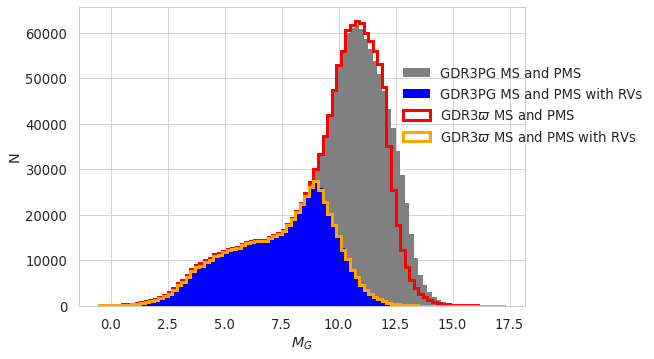

In [32]:
MGbins=np.arange(-0.5,17.5,0.2)
plt.hist(gdr3pgMSPMS.MG,bins=MGbins,histtype='stepfilled',color='grey',linewidth=0,label='GDR3PG MS and PMS');
plt.hist(gdr3pgRVMSPMS.MG,bins=MGbins,histtype='stepfilled',color='blue',linewidth=0,label='GDR3PG MS and PMS with RVs');
plt.hist(gdr3MSPMS.MG,bins=MGbins,histtype='step',color='red',linewidth=3,label=r'GDR3$\varpi$ MS and PMS');
plt.hist(gdr3RVMSPMS.MG,bins=MGbins,histtype='step',color='orange',linewidth=3,label=r'GDR3$\varpi$ MS and PMS with RVs');
plt.ylabel('N')
plt.xlabel(r'$M_G$')
plt.legend(loc=0, bbox_to_anchor=(0.7,0.5))
plt.show()